In [1]:
import mining_env

In [2]:
board_shape = (12, 16)
max_energy = 120
minor_rewards = 0.01

In [3]:
env = mining_env.MiningEnv(board_shape=board_shape, max_energy=max_energy, minor_rewards=minor_rewards)
env.render()

Energy: 120
Dust:
[[3 5 5 4 5 4 4 2 2 2 5 4 4 3 4 4]
 [2 3 2 2 2 5 4 3 2 4 5 2 2 5 3 5]
 [4 3 3 3 5 2 4 4 4 5 4 3 2 4 4 4]
 [5 5 2 3 4 4 5 3 4 2 4 2 2 3 4 3]
 [3 5 3 3 3 3 5 4 4 4 3 2 3 2 4 2]
 [5 5 4 2 2 2 4 3 2 3 3 4 3 3 3 5]
 [2 4 3 2 3 2 2 2 3 2 3 3 3 3 4 5]
 [4 4 2 3 2 3 2 2 2 5 4 3 2 2 2 4]
 [3 4 5 4 3 3 2 3 2 2 4 4 2 2 3 2]
 [3 3 5 5 2 2 3 2 2 2 2 2 2 2 2 3]
 [2 5 4 4 4 5 5 4 3 5 4 5 4 3 2 3]
 [5 5 2 2 5 3 5 5 2 4 2 2 2 3 2 3]]
Retrieved: [0 0 0 0 0]
Rewards on board (number = unretrieved, * = retrieved):
. . . . . . . 4 4 . . . . . . .
. . . . . 4 . . 4 . . . . . . .
. . . . . . 4 4 . . . . . . . .
. . . . . . . . . . . . . . . .
1 1 1 1 . . . . . . . . . . . .
1 1 1 1 . . . . . . . . . . . .
. 1 1 . . . . . . . . . . . . .
. . . . . 5 5 5 . 3 3 3 . . . .
. . . . . 5 5 5 . 3 3 3 2 2 2 2
. . . . . 5 5 5 . 3 3 3 2 2 2 2
. . . . . . . . . . . . 2 2 . 2
. . . . . . . . . . . . . . . .


In [4]:
# try initializing the environment 20000 times to ensure it works
if False:
    for _ in range(20000):
        env = mining_env.MiningEnv(board_shape=board_shape, max_energy=max_energy, minor_rewards=minor_rewards)
        env.reset()

In [5]:
# You can run this in a Jupyter cell.
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

In [6]:
class LocationNet(nn.Module):
    def __init__(self, board_shape):
        super().__init__()
        c, h, w = 1, *board_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        conv_out_h = h // 4
        conv_out_w = w // 4
        self.fc = nn.Sequential(
            nn.Linear(128 * conv_out_h * conv_out_w + 1 + 5, 256), nn.ReLU(),
            nn.Linear(256, h * w), nn.Softmax(dim=1)
        )
        self.h = h
        self.w = w

    def forward(self, dust, energy, retrieved):
        x = dust.unsqueeze(1).float()
        x = self.conv(x)
        x = x.flatten(1)
        energy = energy.float().view(x.shape[0], 1)
        retrieved = retrieved.float().view(x.shape[0], -1)
        x = torch.cat([x, energy, retrieved], dim=1)
        logits = self.fc(x)
        return logits.view(-1, self.h, self.w)  # (B, H, W)

In [7]:
class ToolNet(nn.Module):
    def __init__(self, board_shape):
        super().__init__()
        c, h, w = 1, *board_shape
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        conv_out_h = h // 4
        conv_out_w = w // 4
        self.fc = nn.Sequential(
            nn.Linear(128 * conv_out_h * conv_out_w + 1 + 5 + 2, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, dust, energy, retrieved, loc):
        x = dust.unsqueeze(1).float()
        x = self.conv(x)
        x = x.flatten(1)
        energy = energy.float().view(x.shape[0], 1)
        retrieved = retrieved.float().view(x.shape[0], -1)
        loc = loc.float().view(x.shape[0], 2)
        x = torch.cat([x, energy, retrieved, loc], dim=1)
        return self.fc(x)  # (B, 2)

In [8]:
def obs_to_tensor(obs, device):
    dust = torch.tensor(obs["dust"]).unsqueeze(0).to(device)
    energy = torch.tensor([obs["energy"]], dtype=torch.float32).to(device)
    retrieved = torch.tensor(obs["retrieved"], dtype=torch.float32).unsqueeze(0).to(device)
    return dust, energy, retrieved

def select_location(loc_net, obs, epsilon, device):
    if random.random() < epsilon:
        h, w = obs["dust"].shape
        return random.randint(0, h-1), random.randint(0, w-1)
    dust, energy, retrieved = obs_to_tensor(obs, device)
    with torch.no_grad():
        logits = loc_net(dust, energy, retrieved)[0]  # (H, W)
    idx = logits.view(-1).argmax().item()
    h, w = obs["dust"].shape
    return idx // w, idx % w

def select_tool(tool_net, obs, loc, epsilon, device):
    if random.random() < epsilon:
        return random.randint(0, 1)
    dust, energy, retrieved = obs_to_tensor(obs, device)
    loc_tensor = torch.tensor([loc], dtype=torch.float32).to(device)
    with torch.no_grad():
        q = tool_net(dust, energy, retrieved, loc_tensor)
    return q.argmax().item()

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, size=10000):
        self.buffer = deque(maxlen=size)
    def push(self, *args):
        self.buffer.append(tuple(args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return map(np.array, zip(*batch))
    def __len__(self):
        return len(self.buffer)

In [9]:
# --- Training Loop ---
env = mining_env.MiningEnv(board_shape=board_shape, max_energy=max_energy, minor_rewards=minor_rewards)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h, w = env.board_shape
loc_net = LocationNet(env.board_shape).to(device)
tool_net = ToolNet(env.board_shape).to(device)
target_loc_net = LocationNet(env.board_shape).to(device)
target_tool_net = ToolNet(env.board_shape).to(device)
target_loc_net.load_state_dict(loc_net.state_dict())
target_tool_net.load_state_dict(tool_net.state_dict())
optimizer = optim.Adam(list(loc_net.parameters()) + list(tool_net.parameters()), lr=1e-3)
buffer = ReplayBuffer(10000)

In [10]:
batch_size = 128
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
target_update = 20

In [11]:
history = []
for episode in range(5000):
    obs, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        # Stage 1: select location
        x, y = select_location(loc_net, obs, epsilon, device)
        # Stage 2: select tool
        tool = select_tool(tool_net, obs, (x, y), epsilon, device)
        action = (x, y, tool)
        next_obs, reward, done, _, _ = env.step(action)
        buffer.push(obs, (x, y), tool, reward, next_obs, done)
        obs = next_obs
        total_reward += reward

        # Train
        if len(buffer) >= batch_size:
            obses, locs, tools, rewards, next_obses, dones = buffer.sample(batch_size)
            # Location update
            dust = torch.from_numpy(np.array([o["dust"] for o in obses])).float().to(device)  # (batch, 1, H, W)
            energy = torch.tensor([o["energy"] for o in obses], dtype=torch.float32).view(-1, 1).to(device)
            retrieved = torch.from_numpy(np.array([o["retrieved"] for o in obses])).float().to(device)
            loc_targets = torch.tensor([l[0]*w + l[1] for l in locs]).to(device)
            loc_logits = loc_net(dust, energy, retrieved)
            # loc_loss = nn.functional.cross_entropy(loc_logits, loc_targets)
            # convert loc_targets to 2D indices
            loc_targets_2d = torch.zeros((batch_size, h, w), dtype=torch.float32).to(device)
            loc_targets_2d[torch.arange(batch_size), loc_targets // w, loc_targets % w] = 1.0
            # calculate loss as l2 distance
            loc_loss = nn.functional.mse_loss(loc_logits, loc_targets_2d)

            # Tool update
            locs_tensor = torch.tensor(locs, dtype=torch.float32).to(device)
            tool_logits = tool_net(dust, energy, retrieved, locs_tensor)
            tool_targets = torch.tensor(tools).to(device)
            tool_loss = nn.functional.cross_entropy(tool_logits, tool_targets)

            loss = loc_loss + tool_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if total_reward>50*minor_rewards:
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
    if episode % target_update == 0:
        target_loc_net.load_state_dict(loc_net.state_dict())
        target_tool_net.load_state_dict(tool_net.state_dict())
    print(f"Episode {episode}, total reward: {total_reward}, epsilon: {epsilon:.3f}")
    history.append(total_reward)

print("Training finished.")

Episode 0, total reward: 0, epsilon: 1.000
Episode 1, total reward: 0.4, epsilon: 1.000
Episode 2, total reward: 0.17, epsilon: 1.000
Episode 3, total reward: 0.16, epsilon: 1.000
Episode 4, total reward: 0.17, epsilon: 1.000
Episode 5, total reward: 0.24, epsilon: 1.000
Episode 6, total reward: 0.1, epsilon: 1.000
Episode 7, total reward: 0.44, epsilon: 1.000
Episode 8, total reward: 0.38, epsilon: 1.000
Episode 9, total reward: 0.09000000000000001, epsilon: 1.000
Episode 10, total reward: 0.12, epsilon: 1.000
Episode 11, total reward: 0.08, epsilon: 1.000
Episode 12, total reward: 0, epsilon: 1.000
Episode 13, total reward: 0.04, epsilon: 1.000
Episode 14, total reward: 0.2, epsilon: 1.000
Episode 15, total reward: 0.19, epsilon: 1.000
Episode 16, total reward: 0.01, epsilon: 1.000
Episode 17, total reward: 17.23, epsilon: 0.995
Episode 18, total reward: 0.05, epsilon: 0.995
Episode 19, total reward: 0.03, epsilon: 0.995
Episode 20, total reward: 0.08, epsilon: 0.995
Episode 21, tota

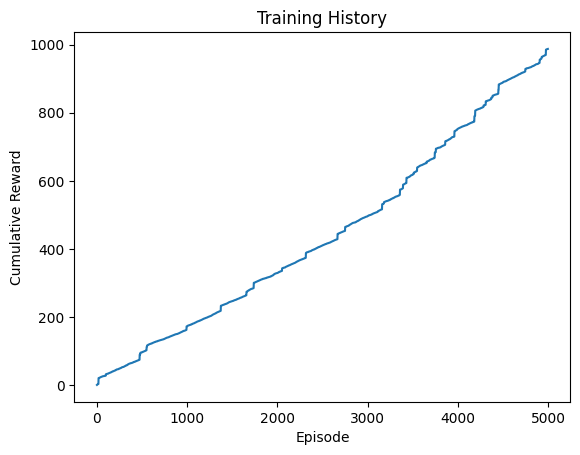

In [12]:
# draw cumulative rewards
import matplotlib.pyplot as plt
plt.plot(np.cumsum(history))
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Training History")
plt.show()